<a href="https://colab.research.google.com/github/fantajeon/DLPytorch1.2/blob/master/MNIST_Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0-9까지 숫자를 생성해내는 GAN입니다.
Author: fantajeon@gmail.com

기여도: pytorch 1.1.0버전에 호환되도록 수정

참조소스: https://kangbk0120.github.io/articles/2017-08/condgan-imple

In [0]:
!pip install -q tqdm

In [0]:
import itertools
import math
import time

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import torch.nn.functional as F
import os
import tqdm
from IPython.core.debugger import set_trace


%matplotlib inline

In [0]:
class Discriminator(nn.Module):
    """Discriminator, 논문에 따르면 maxout을 사용하지만
       여기서는 그냥 Fully-connected와 LeakyReLU를 사용하겠습니다.
       논문에서는 Discriminator의 구조는 그렇게 중요하지 않다고 말합니다"""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x, y):
        # x는 minibatch x 1(채널 수) x 28 x 28(가로, 세로)입니다
        x = x.view(x.size(0), 784) # x를 minibatch x 784로 바꿔줍니다
        #out = self.model(torch.cat([x,y], 1))
        out = self.model(x)
        out = out.view(out.size(0), -1)
        return out

In [0]:
class Generator(nn.Module):
    """Generator, 논문에 따르면 100개의 noise를 hypercube에서 동일한 확률값으로 뽑고
       z를 200개, y를 1000개의 뉴런으로 전달합니다. 이후 1200차원의 ReLU layer로 결합하고
       Sigmoid를 통해 숫자를 만들어냅니다."""
    def __init__(self):
        super().__init__()
        self.map = nn.Sequential(
            nn.Linear(100+10, 256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, 512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.5),

            nn.Linear(512, 1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.5),

            nn.Linear(1024, 784),
            nn.Tanh()
        )
    def forward(self, z, y):
        out = self.map(torch.cat([z, y], 1))
        return out

In [0]:
discriminator = Discriminator()
generator = Generator()

criterion = nn.BCELoss()      
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [0]:
def train_discriminator(discriminator, x, real_labels, fake_images, fake_labels, y):
    discriminator.zero_grad()
    outputs = discriminator(x, y)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs

    outputs = discriminator(fake_images, y)
    fake_loss = criterion(outputs, fake_labels)
    fake_score = fake_loss

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

def train_generator(generator, discriminator_outputs, real_labels, y):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)

    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [0]:
batch_size = 100

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

mnist_trainset = dsets.MNIST(root='./data', train=True, download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True, num_workers=5)

0it [00:00, ?it/s]

9920512it [00:08, 1162470.26it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 138655.24it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:02, 767702.43it/s]                              
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 52143.88it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
train_iter = iter(train_dataloader)
X, y = next(train_iter)

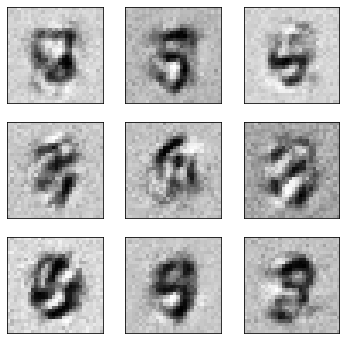

step: 3200 d_loss: 0.0763, g_loss: 8.7500, D(x): 1.00, D(G(z)): 0.07


RuntimeError: ignored

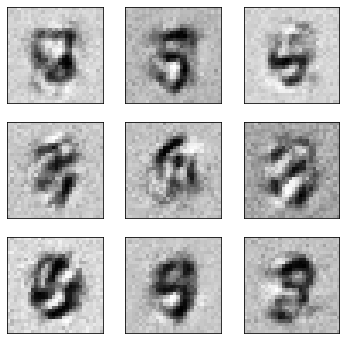

In [0]:
num_test_samples = 9
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)


num_epoch = 200
batch_num = 5500
num_fig = 0

generator.train()

tracking_dict = {}
tracking_dict["d_loss"] = []
tracking_dict["g_loss"] = []
tracking_dict["real_score"] = []
tracking_dict["fake_score"] = []

train_iter = iter(train_dataloader)
for it in tqdm.tqdm_notebook(range(120000)):
  for _ in range(10):
    z = torch.randn(batch_size, 100)
    try:
      X, y = next(train_iter)
    except StopIteration:
      train_iter = iter(train_dataloader)
      X, y = next(train_iter)
    y = F.one_hot(y).type(torch.float32)
    with torch.no_grad():
      fake_images = generator(z, y)

    real_labels = torch.ones(batch_size, dtype=torch.float32)
    fake_labels = torch.zeros(batch_size, dtype=torch.float32)

    # Discriminator 학습
    d_loss, real_score, fake_score = train_discriminator(discriminator, X, real_labels,\
                                                         fake_images, fake_labels,y)
  # minibatch x 100의 noise를 무작위로 뽑습니다
  z = torch.randn(batch_size, 100, dtype=torch.float32)
  fake_images = generator(z, y)
  outputs = discriminator(fake_images, y)

  g_loss = train_generator(generator, outputs, real_labels, y)
  # 100번마다 결과를 출력합니다
  # 임의로 9개의 noise를 뽑고,
  # 1~9까지를 one-hot encoding한다음 위에서 만든 noise와 concat합니다
  if (it+1) % 100 == 0:
      z = torch.randn(9, 100)
      c = np.eye(9, dtype='float32')
      c = np.c_[np.zeros(9), c]
      test_images = generator(z, torch.from_numpy(c).type(torch.float32))

      # 이미지를 쥬피터 노트북에 띄웁니다.
      if not os.path.exists('results/'):
          os.makedirs('results/')
      for k in range(num_test_samples):
          i = k//3
          j = k%3
          ax[i,j].cla()
          ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
      display.clear_output(wait=True)
      display.display(plt.gcf())

      plt.savefig('results/mnist-gan-%03d.png'%num_fig)
      num_fig += 1
      print('step: %d d_loss: %.4f, g_loss: %.4f, '
            'D(x): %.2f, D(G(z)): %.2f'
            %(it+1, d_loss.item(), g_loss.item(),
              real_score.data.mean().item(), fake_score.data.mean().item()))
      tracking_dict["d_loss"].append(d_loss.item())
      tracking_dict["g_loss"].append(g_loss.item())
      tracking_dict["real_score"].append(real_score.data.mean().item())
      tracking_dict["fake_score"].append(fake_score.data.mean().item())

In [0]:
c = np.zeros([12,10]) 
c[0, 0] = 1
c[1, 1] = 1
c[2, 0] = 1
c[3, 7] = 1
c[4, 7] = 1
c[5, 2] = 1
c[6, 2] = 1
c[7, 0] = 1
c[8, 1] = 1
c[9, 1] = 1
c[10, 3] = 1
c[11, 8] = 1

In [0]:

generator.eval()

num_test_samples = c.shape[0]
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(3, 4)
for i, j in itertools.product(range(3), range(4)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
z = torch.randn(num_test_samples, 100)
test_images = generator(z, torch.from_numpy(c).type(torch.float32))
for i, j in itertools.product(range(3), range(4)):
  k = i*4 + j
  ax[i,j].cla()
  ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
display.clear_output(wait=True)
#display.display(plt.gcf())
#plt.savefig('results/mnist-gan-phone.png')

In [0]:
ax.shape